In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
hdu_list = fits.open('specgrid.fits')
logwave = hdu_list['LOGWAVE'].data
flux = hdu_list['FLUX'].data

Text(0.5, 0, 'wavelength [$A$]')

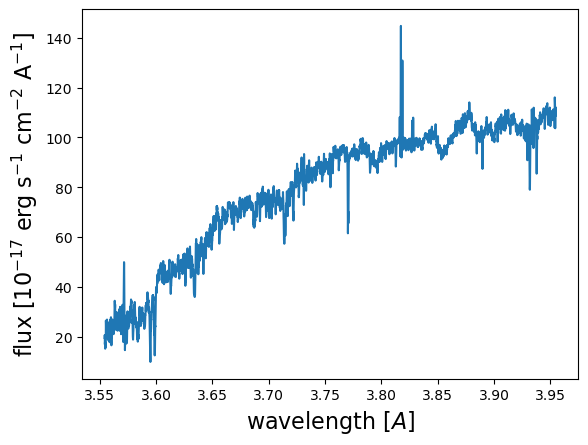

In [3]:
plt.plot(logwave, flux[0, :])
plt.ylabel('flux [$10^{−17}$ erg s$^{−1}$ cm$^{−2}$ A$^{-1}$]', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)

(0.0, 2.0)

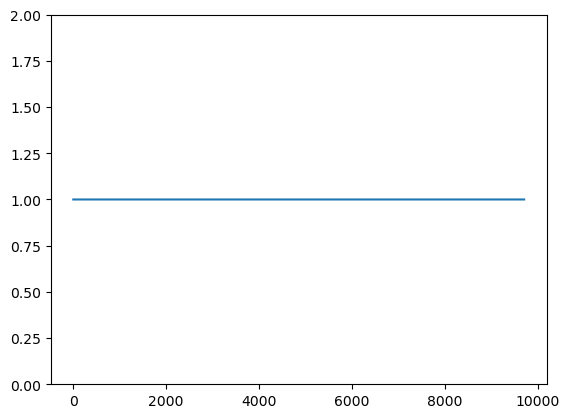

In [4]:
# Calculate the total flux for each galaxy
flux_sum = np.sum(flux, axis=1)

# Normalize each galaxy's flux by dividing by its total flux
flux_normalized = flux / np.tile(flux_sum, (np.shape(flux)[1], 1)).T

# Check that the data is properly normalized
plt.plot(np.sum(flux_normalized, axis=1))
plt.ylim(0, 2)

Text(0.5, 0, 'wavelength [$A$]')

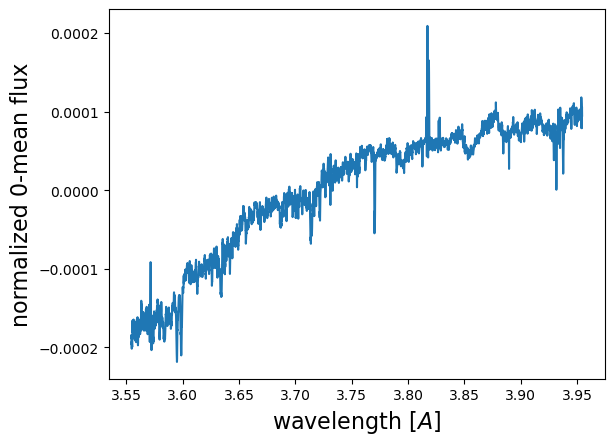

In [5]:
# Calculate the mean spectrum of the normalized spectra
means_normalized = np.mean(flux_normalized, axis=1)

# Subtract the mean spectrum from the normalized spectra
flux_normalized_0_mean = flux_normalized - np.tile(means_normalized, (np.shape(flux)[1], 1)).T

# Plot the 0-mean normalized flux for the first galaxy
plt.plot(logwave, flux_normalized_0_mean[0, :])
plt.ylabel('normalized 0-mean flux', fontsize=16)
plt.xlabel('wavelength [$A$]', fontsize=16)

In [6]:
def sorted_eigs(r, return_eigvalues = False):
    """
    Calculate the eigenvectors and eigenvalues of the correlation matrix of r
    -----------------------------------------------------
    """
    corr=r.T@r
    eigs=np.linalg.eig(corr) #calculate eigenvectors and values of original 
    arg=np.argsort(eigs[0])[::-1] #get indices for sorted eigenvalues
    eigvec=eigs[1][:,arg] #sort eigenvectors
    eig = eigs[0][arg] # sort eigenvalues
    if return_eigvalues == True:
        return eig, eigvec
    else:
        return eigvec
# here I'll use data for only the first 500 galaxies because my computer is slow!
r = flux_normalized_0_mean 
r_subset = r[:500, :]
logwave_subset = logwave
C = r_subset.T@r_subset # correlation matrix, dimension # wavelengths x # wavelengths
# check dimensions of correlation matrix
C.shape
# check dimension of data matrix for 500 galaxies
r_subset.shape

(500, 4001)

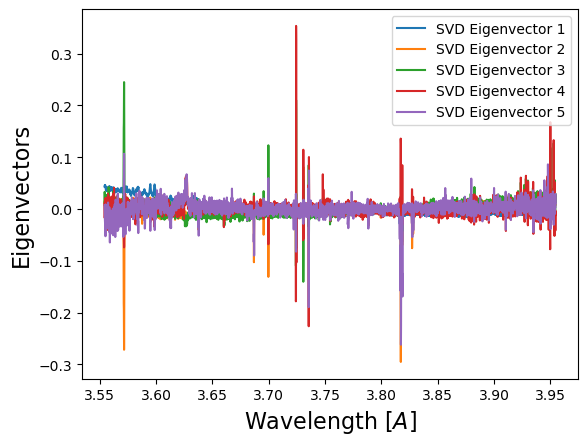

In [7]:
# MARCO CODE!
def sorted_eigs(r, return_eigvalues=False):
    """
    Calculate the eigenvectors and eigenvalues of the correlation matrix of r
    -----------------------------------------------------
    """
    corr = r.T @ r
    eigs = np.linalg.eig(corr)  # calculate eigenvectors and values of the correlation matrix
    arg = np.argsort(eigs[0])[::-1]  # get indices for sorted eigenvalues
    eigvec = eigs[1][:, arg]  # sort eigenvectors
    eig = eigs[0][arg]  # sort eigenvalues
    if return_eigvalues:
        return eig, eigvec
    else:
        return eigvec

# Specify the subset size (e.g., 500 galaxies)
subset_size = 5
r = flux_normalized_0_mean
r_subset = r[:subset_size, :]
logwave_subset = logwave

# Calculate the correlation matrix
C = r_subset.T @ r_subset  # correlation matrix, dimension # wavelengths x # wavelengths

# Perform PCA using SVD
U, S, Vh = np.linalg.svd(r_subset, full_matrices=True)
eigvecs_svd = Vh.T
eigvals_svd = S**2
svd_sort = np.argsort(eigvals_svd)[::-1]
eigvecs_svd = eigvecs_svd[:, svd_sort]
eigvals_svd = eigvals_svd[svd_sort]

# Perform PCA using the correlation matrix
eigvals, eigvecs = sorted_eigs(r_subset, return_eigvalues=True)

# Plot the first five eigenvectors
for i in range(5):
    plt.plot(logwave_subset, eigvecs_svd[:, i], label=f'SVD Eigenvector {i+1}')

plt.xlabel('Wavelength [$A$]', fontsize=16)
plt.ylabel('Eigenvectors', fontsize=16)
plt.legend()
plt.show()

Text(0, 0.5, 'Eig eigenvalues')

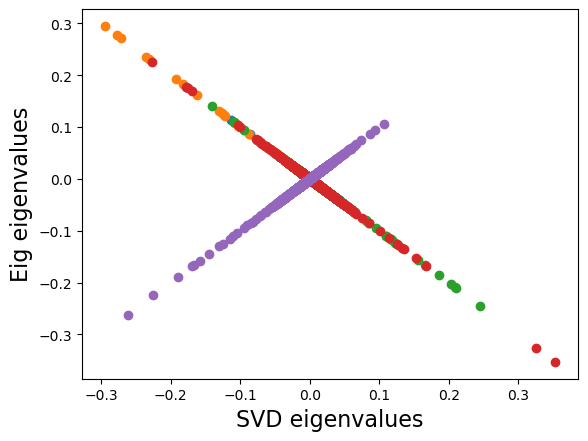

In [8]:
[plt.plot(eigvecs_svd[:,i], eigvecs[:,i], 'o')for i in range(5)]
plt.xlabel('SVD eigenvalues', fontsize = 16)
plt.ylabel('Eig eigenvalues', fontsize = 16)

Text(0, 0.5, 'Eig eigenvalues')

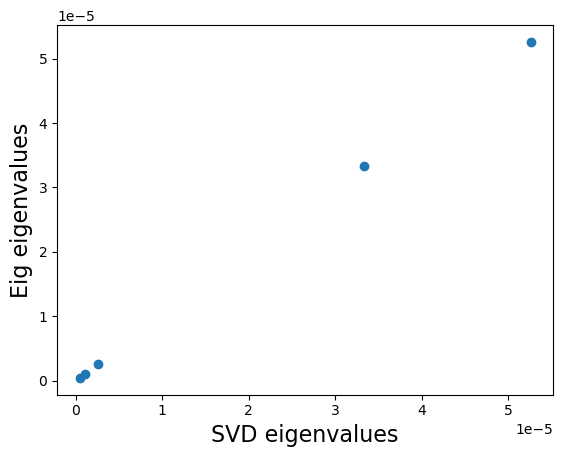

In [11]:
plt.plot(eigvals_svd, eigvals[:5], 'o')
plt.xlabel('SVD eigenvalues', fontsize = 16)
plt.ylabel('Eig eigenvalues', fontsize = 16)

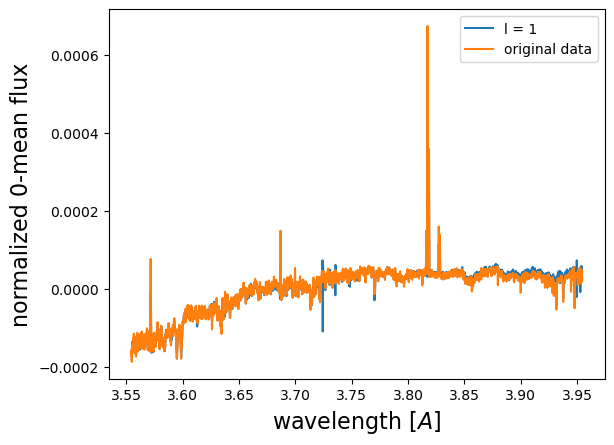

In [13]:
def PCA(l, r, project = True):
    """
    Perform PCA dimensionality reduction
    --------------------------------------------------------------------------------------
    """
    eigvector = sorted_eigs(r)
    eigvec=eigvector[:,:l] #sort eigenvectors, only keep l
    reduced_wavelength_data= np.dot(eigvec.T,r.T) #np.dot(eigvec.T, np.dot(eigvec,r.T))
    if project == False:
        return reduced_wavelength_data.T # get the reduced wavelength weights
    else: 
        return np.dot(eigvec, reduced_wavelength_data).T # multiply eigenvectors by 
                                                        # weights to get approximate spectrum
# Using only the first eigenvector does not capture the entire signal well!
nc = 1 
plt.plot(logwave_subset, PCA(nc,r_subset)[1,:], label = 'l = {Nc}'.format(Nc = nc))
plt.plot(logwave_subset, r_subset[1,:], label = 'original data')

plt.ylabel('normalized 0-mean flux', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)
plt.legend()

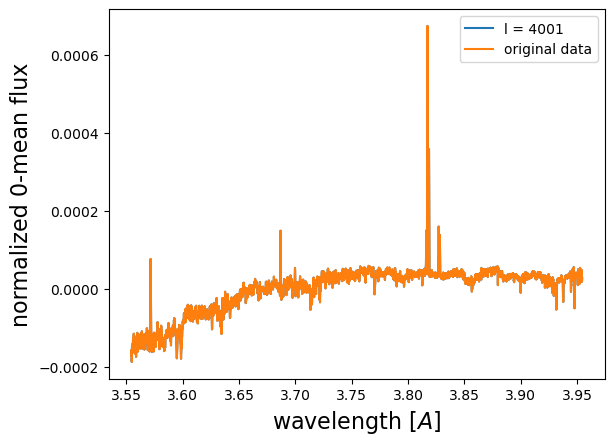

In [14]:
# check to make sure that using all eigenvectors reconstructs original signal

nc = 4001
plt.plot(logwave_subset, PCA(nc,r_subset)[1,:], label = 'l = {Nc}'.format(Nc = nc))
plt.plot(logwave_subset, r_subset[1,:], label = 'original data')

plt.ylabel('normalized 0-mean flux', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)
plt.legend()

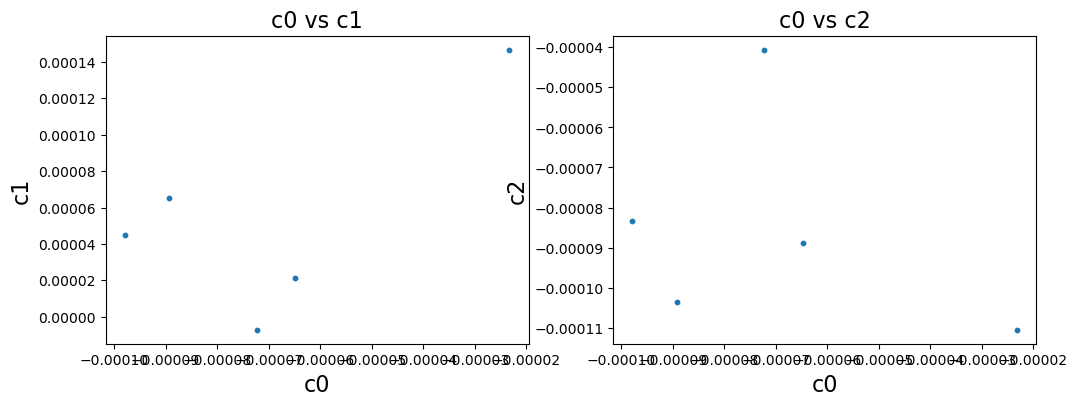

In [15]:
# Calculate the PCA coefficients (c0, c1, c2)
coefficients = np.dot(eigvecs, r_subset.T)

# Extract c0, c1, and c2
c0 = coefficients[0, :]
c1 = coefficients[1, :]
c2 = coefficients[2, :]

# Create plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(c0, c1, s=10)
plt.xlabel('c0', fontsize=16)
plt.ylabel('c1', fontsize=16)
plt.title('c0 vs c1', fontsize=16)

plt.subplot(1, 2, 2)
plt.scatter(c0, c2, s=10)
plt.xlabel('c0', fontsize=16)
plt.ylabel('c2', fontsize=16)
plt.title('c0 vs c2', fontsize=16)

plt.show()

In [ ]:
import numpy as np

# Initialize an array to store the squared fractional residuals
squared_residuals = []

# Create an array to store Nc values from 1 to 20
Nc_values = np.arange(1, 21)

# Calculate the squared fractional residuals for each Nc
for Nc in Nc_values:
    # Calculate the approximate spectra for the current Nc
    approximated_spectra = approximate_spectrum(r_subset, eigvecs, eigvals, Nc)

    # Compute the squared differences between original and approximate spectra
    squared_diff = np.sum((r_subset - approximated_spectra) ** 2)

    # Compute the squared sum of the original spectra
    squared_original_sum = np.sum(r_subset ** 2)

    # Calculate the squared fractional residual
    squared_residual = squared_diff / squared_original_sum

    squared_residuals.append(squared_residual)

# Plot the squared fractional residuals as a function of Nc
plt.plot(Nc_values, squared_residuals, marker='o')
plt.xlabel('Number of Coefficients (Nc)', fontsize=14)
plt.ylabel('Squared Fractional Residuals', fontsize=14)
plt.title('Squared Fractional Residuals vs. Nc', fontsize=16)
plt.grid(True)
plt.show()

# Print the squared fractional error for Nc = 20
print(f'Squared Fractional Error for Nc = 20: {squared_residuals[-1]:.6f}')